In [2]:
from os.path import join as ospj
from copy import deepcopy

In [3]:
### If using Colab, uncomment the two following lines to mount your Google Drive.

from google.colab import drive
drive.mount('/content/drive')


### If using Colab, change the PROJECT_ROOT to where you've uploaded the project.
### E.g. PROJECT_ROOT='/content/drive/MyDrive/TeamX/'
### You may also need to change the `data_dir`, `save_dir`, paths in the `cfgs/exercise_3/` configs.

PROJECT_ROOT='/content/drive/MyDrive/Colab Notebooks/HLCV Assignment_3'
import sys
sys.path.append(PROJECT_ROOT)

Mounted at /content/drive


In [ ]:
# Just so that you don't have to restart the notebook with every change.
%load_ext autoreload
%autoreload 2

In Exercise 3, you will implement a convolutional neural network to perform image classification and explore methods to improve the training performance and generalization of these networks.
We will use the CIFAR-10 dataset as a benchmark for our networks, similar to the previous exercise. This dataset consists of 50000 training images of 32x32 resolution with 10 object classes, namely airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. The task is to implement a convolutional network to classify these images using the PyTorch library. The four questions are,

- Implementing a convolutional neural network, training it, and visualizing its weights (Question 1).
- Experiment with batch normalization and early stopping (Question 2).
- Data augmentation and dropout to improve generalization (Question 3).
- Implement transfer learning from an ImageNet-pretrained model (Question 4).

Before we begin, here are a few remarks regarding the codebase for this assignment.


For every experiment, you would define a config dictionary (see the dictionary in `./cfgs/exercise_3/cnn_cifar10.py`). Every config dictionary, will have the configuration for
- data (e.g batch size, shuffle, which DataModule to use, splitting)
- model (e.g which class module to use and what arguments to pass to it)
- training (e.g type of optimizer, lr_scheduler, n_epochs etc.)

The DataModules are located at  `src/data_loaders/` and they inherit from a base_data_module that handles things such as splitting the data (see `src/data_loaders/base_data_modules.py`). A sample datamodule may inherit from this class (e.g `src/data_loaders/data_modules.py`). The main concern is that datamodule initialization should get everything ready, so that one can simply get the dataloaders for train/held-out sets from it (see `get_loader` and `get_heldout_loader` in BaseDataModule). The data augmentations are also done in a preset fation. One defines the preset in `utils/transform_presets.py` and simply specifies the *preset key* in the config for datamodule.

The models are defined in `src/models/` (see for instance `src/models/cnn/model.py`). These are typical Pytorch nn.Modules that we had also seen in Assignment 2. They might additionally have extra methods such as `VisualizeFilter` in `model.py`.

The Trainer glues everything together. It creates the model, sets up optimizer, lr_schduler etc. and has the option to `train()` or `evaluate()` a model over the given dataloaders. It also logs everything in `Logs/YOUR_EXP_NAME.log` and saves the checkpoints under the `Saved/YOUR_EXP_NAME/`. Please familirize yourself with the `__init__` and methods of both `trainers/base_trainer.py` and `trainers/cnn_trainer.py` before continuing with the assignment.

Lastly, for tracking different metrics (top(1/5) (train/val) accuracy or losses), we use a MetricTracker object defined in `src/utils/utils.py`. A single tracker keeps track of multiple metric keys and can `update()` their history by adding new values to a list. In the end, it can be used to return an average of a metric.


Feel free to ask questions on the forum if part of the codebase is confusing.


### Question 1: Implement Convolutional Network (10 points)

In this question, we will implement a five-layered convolutional neural network architecture as well as the loss function to train it. Refer to the comments in the code to the exact places where you need to fill in the code.

![Failed to load the image. Please view it yourself at ./data/exercise-3/fig1_resized.png](./data/exercise-3/fig1_resized.png)

Our architecture is shown in Fig 1. It has five convolution blocks. Each block is consist of convolution, max pooling, and ReLU operation in that order. We will use 3×3 kernels in all convolutional layers. Set the padding and stride of the convolutional layers so that they maintain the spatial dimensions. Max pooling operations are done with 2×2 kernels, with a stride of 2, thereby halving the spatial resolution each time. Finally, stacking these five blocks leads to a 512 × 1 × 1 feature map. Classification is achieved by a fully connected layer. We will train convolutional neural networks on the CIFAR-10 dataset. Implement a class ConvNet to define the model described. The ConvNet takes 32 × 32 color images as inputs and has 5 hidden layers with 128, 512, 512, 512, 512 filters, and produces a 10-class classification.

a) Please implement the above network (initialization and forward pass) in class `ConvNet` in `models/cnn/model.py`. The code to train the model is already provided in the `trainers/base_trainer.py`'s train() and `trainers/cnn_trainer`'s _train_epoch(). Train the above model and report the training and validation accuracies. (5 points)

b) Implement the method `__str__` in `models/base_model.py`, which should give a string representaiton of the model. The string should show the number of `trainable` parameters for each layer. This gives us a measure of model capacity. Also at the end, it should print the total number of trainable parameters for the entire model. (2 points)

c) Implement a function `VisualizeFilter` in `models/cnn/model.py`, which visualizes the filters of the first convolution layer implemented in Q1.a. In other words, you need to show 128 filters with size 3x3 as color images (since each filter has three input channels). Stack these into 3x3 color images into one large image. You can use the `imshow` function from the `matplotlib` library to visualize the weights. See an example in Fig. 2

![Failed to load the image. Please view it yourself at ./data/exercise-3/fig2_resized.png](./data/exercise-3/fig2_resized.png)

Compare the filters before and after training. Do you see any patterns? (3 points). Please attach your output images before and after training in a cell with your submission.

In [ ]:
from cfgs.exercise_3 import cnn_cifar10
q1_config = cnn_cifar10.q1_experiment

datamodule_class = q1_config['datamodule']
data_args = q1_config['data_args']

dm = datamodule_class(**data_args)

# Based on the heldout_split in the config file,
# the datamodule will break the dataset into two splits
train_data_loader = dm.get_loader()
valid_data_loader = dm.get_heldout_loader()

# Test loader is the same as train loader
# except that training=False, shuffle=False, and no splitting is done
# So we use the exact config from training and just modify these arguments
test_data_args = deepcopy(data_args) # copy the args
test_data_args['training'] = False
test_data_args['shuffle'] = False
test_data_args['heldout_split'] = 0.0

# Now we initialize the test module with the modified config
test_dm = datamodule_class(**test_data_args)
test_loader = test_dm.get_loader() # and get the loader from it

transforms for preset CIFAR10 for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}
transforms for preset CIFAR10 for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}


In [ ]:
# import shutil
# import os

# # Function to delete a directory if it exists
# def clean_directory(path):
#     if os.path.exists(path):
#         shutil.rmtree(path)


# # Define paths
# log_dir = '/content/drive/MyDrive/Colab Notebooks/HLCV Assignment_3/Logs'
# save_dir = '/content/drive/MyDrive/Colab Notebooks/HLCV Assignment_3/Saved'
# # Clean up old logs and saved models
# clean_directory(log_dir)
# clean_directory(save_dir)

# # Now re-create the log and save directories
# os.makedirs(log_dir, exist_ok=True)
# os.makedirs(save_dir, exist_ok=True)

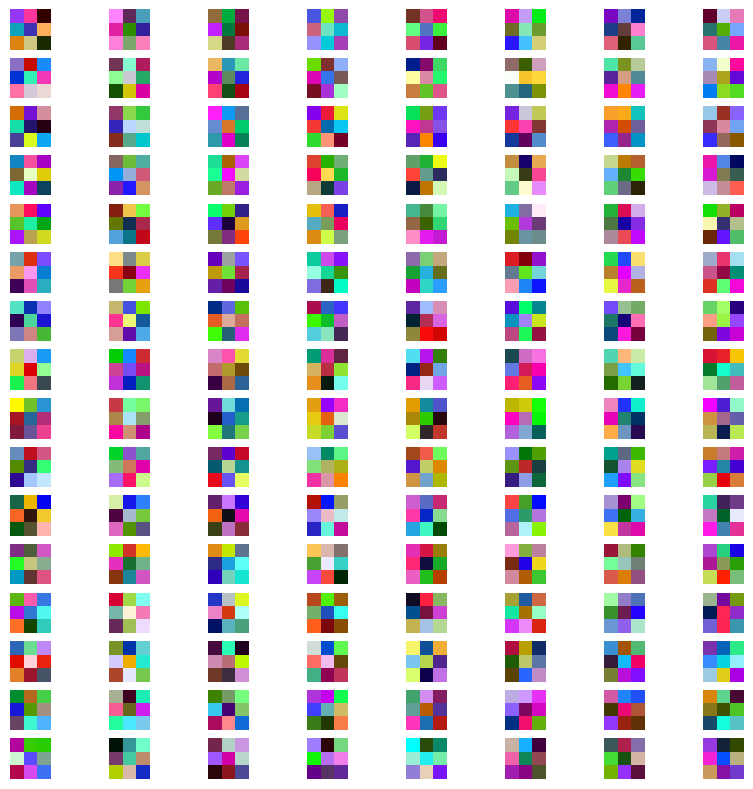

  0% 0/45000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Train Epoch: 1 Loss: 0.9749: : 100% 45000/45000 [00:22<00:00, 1971.70it/s]
Eval Loss: 1.2292: : 100% 5000/5000 [00:09<00:00, 554.56it/s]
Train Epoch: 2 Loss: 1.0071: : 100% 45000/45000 [00:20<00:00, 2150.67it/s]
Eval Loss: 1.2431: : 100% 5000/5000 [00:06<00:00, 76

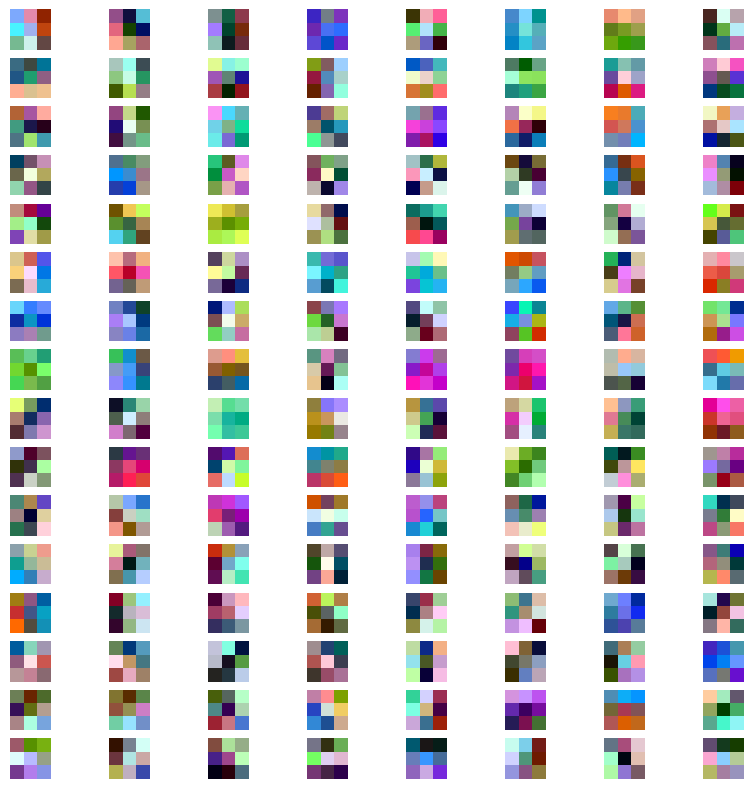

In [ ]:
trainer_class = q1_config['trainer_module']
trainer_cnn = trainer_class(
    config = q1_config,
    log_dir = ospj(PROJECT_ROOT,'Logs'),
    train_loader=train_data_loader,
    eval_loader=valid_data_loader,
)

trainer_cnn.model.VisualizeFilter()
trainer_cnn.train()
trainer_cnn.model.VisualizeFilter()

In [ ]:
# Change this to the experiment you want to evaluate
path = '/content/drive/MyDrive/Colab Notebooks/HLCV Assignment_3/Saved/CIFAR10_CNN_1Q/last_model.pth'
trainer_cnn.load_model(path=path)

result = trainer_cnn.evaluate(loader=test_loader)

print(result)

Eval Loss: 0.9092: : 100% 10000/10000 [00:16<00:00, 612.42it/s]

{'loss': 0.7356437945365906, 'top1': 0.7639999999999998, 'top5': 0.9827999999999997}


In [ ]:
# Printing the model summary to see the parameters
print(trainer_cnn.model)

ConvNet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): ReLU()
    (8): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
    (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stat

#Report on Convolutional Filters Before and After Training on CIFAR-10 Dataset

##Introduction
In this report, we analyze the convolutional filters of the first convolutional layer of a Convolutional Neural Network (CNN) before and after training on the CIFAR-10 dataset. The CIFAR-10 dataset consists of 50000 training images of 32x32 resolution with 10 object classes. The CNN is designed to classify these images into their respective categories.

###Filters Before Training
Before training, the filters in the first convolutional layer are initialized randomly.These initial filters do not have any specific patterns and look like random noise. Here are some observations of the filters before training:
- Random Patterns: The filters appear as random speckles and do not exhibit any coherent structure.

- Lack of Features: No discernible edges, textures, or shapes can be identified.

###Filters After Training
After training, the filters in the first convolutional layer have learned to detect various low-level features from the CIFAR-10 images. These features are crucial for the subsequent layers to build more complex representations of the input data. Here are some key observations:

- Edge Detection: Many filters have become edge detectors, highlighting boundaries and edges within the images.
- Color Sensitivity: Some filters have specialized in detecting specific colors or color transitions.
- Directional Features: Filters may show preference for specific orientations (e.g., horizontal, vertical, or diagonal lines).

###Comparative Analysis
- Pattern Formation: Before training, filters are random and lack structure. After training, they develop clear patterns that correspond to meaningful features in the input data.
- Specialization: Post-training filters show specialization, such as edge detection or color sensitivity, which are crucial for the classification task.
- Noise Reduction: The randomness seen in the initial filters is significantly reduced, resulting in more coherent and interpretable filter patterns.

### Conclusion
The analysis of the first convolutional layer's filters before and after training on the CIFAR-10 dataset reveals a significant transformation. Initially, the filters are random and unstructured. After training, they evolve into specialized feature detectors that are essential for the network's ability to classify images effectively. This change underscores the power of convolutional neural networks to learn and extract meaningful features from raw image data.
<br>
<br>
<br>
![Failed to load the image. Please view it yourself at ./data/exercise-3/fig2_resized.png](./data/exercise-3/before_training.png)

![Failed to load the image. Please view it yourself at ./data/exercise-3/fig2_resized.png](./data/exercise-3/after_training.png)

### Question 2: Improve training of Convolutional Networks (15 points)

a) Batch normalization is a widely used operation in neural networks, which will increase the speed of convergence and reach higher performance. You can read the paper “Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift” for more theoretical details.
In practice, these operations are implemented in most toolboxes, such as PyTorch and TensorFlow. Add batch normalization in the model of Q1.a (You can use PyTorch's implementation). Please keep other hyperparameters the same, but only add batch normalization. The ConvNet with batch normalization still uses the same class with Q1.a but different arguments. Check the code for details. In each block, the computations should be in the order of **[convolution -> batch normalization -> pooling -> ReLU]**. Compare the loss curves and accuracy using batch normalization to its counterpart in Q1.a. (5 points)

In order to run this experiment, please create a new config dictionary in `cnn_cifar10.py` under the name `q2a_normalization_experiment` (Hint: most of it should be similar to Q1's config). Don't forget to assign the config a new name, so that it doesn't overwrite previous experiments. Similar to the above cells, import the config and run the experiment.

You can also add extra code to `base_trainer.py` or `cnn_trainer.py` so that they return extra information after the training is finished. For example, recall that in assignment 2's `models/twolayernet/model.py` we had a train method that would return the history of loss values, and then in the notebook the history was plotted with matplotlib. Feel free to make adjustments that let you better understand what's happening. This also applies to next questions. Right now the code only uses tensorboard and wandb for plotting (if enabled in config).

transforms for preset CIFAR10 for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}
transforms for preset CIFAR10 for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}


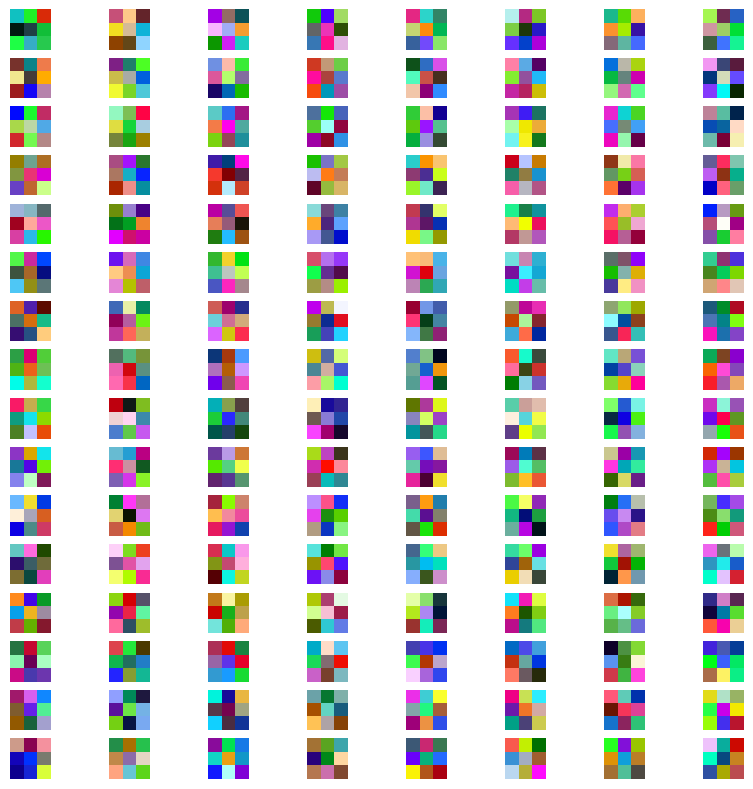

Train Epoch: 1 Loss: 1.0698: : 100% 45000/45000 [00:22<00:00, 2020.86it/s]
Eval Loss: 1.2831: : 100% 5000/5000 [00:07<00:00, 691.65it/s]
Train Epoch: 2 Loss: 0.8144: : 100% 45000/45000 [00:23<00:00, 1909.86it/s]
Eval Loss: 1.3269: : 100% 5000/5000 [00:06<00:00, 716.55it/s]
Train Epoch: 3 Loss: 0.8283: : 100% 45000/45000 [00:21<00:00, 2097.56it/s]
Eval Loss: 1.2868: : 100% 5000/5000 [00:14<00:00, 350.13it/s]
Train Epoch: 4 Loss: 0.6497: : 100% 45000/45000 [00:21<00:00, 2098.66it/s]
Eval Loss: 1.1309: : 100% 5000/5000 [00:06<00:00, 759.48it/s]
Train Epoch: 5 Loss: 0.5777: : 100% 45000/45000 [00:21<00:00, 2077.09it/s]
Eval Loss: 0.6555: : 100% 5000/5000 [00:09<00:00, 519.50it/s]
Train Epoch: 6 Loss: 0.5394: : 100% 45000/45000 [00:21<00:00, 2088.49it/s]
Eval Loss: 0.6838: : 100% 5000/5000 [00:06<00:00, 762.95it/s]
Train Epoch: 7 Loss: 0.4497: : 100% 45000/45000 [00:21<00:00, 2093.42it/s]
Eval Loss: 0.6433: : 100% 5000/5000 [00:09<00:00, 536.40it/s]
Train Epoch: 8 Loss: 0.5289: : 100% 45000

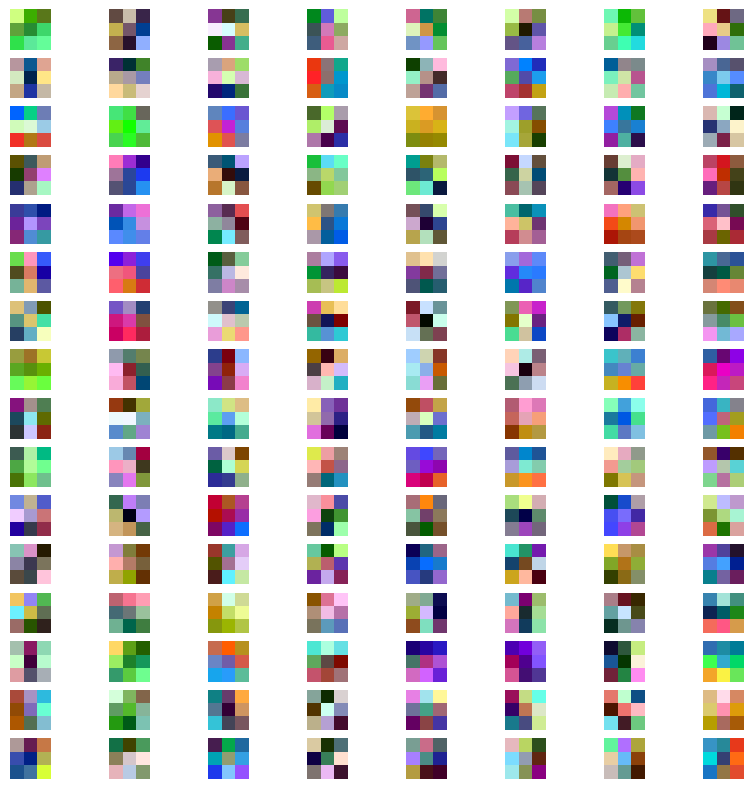

ConvNet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): ReLU()
    (8): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
    (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stat

Eval Loss: 0.6965: : 100% 10000/10000 [00:16<00:00, 619.25it/s]

{'loss': 0.6830441838502884, 'top1': 0.7798000000000002, 'top5': 0.9838}


In [ ]:
from cfgs.exercise_3 import cnn_cifar10
q2a_config = cnn_cifar10.q2a_normalization_experiment

datamodule_class = q2a_config['datamodule']
data_args = q2a_config['data_args']

dm = datamodule_class(**data_args)

train_data_loader = dm.get_loader()
valid_data_loader = dm.get_heldout_loader()


test_data_args = deepcopy(data_args) # copy the args
test_data_args['training'] = False
test_data_args['shuffle'] = False
test_data_args['heldout_split'] = 0.0

test_dm = datamodule_class(**test_data_args)
test_loader = test_dm.get_loader()
trainer_class = q2a_config['trainer_module']
trainer_cnn = trainer_class(
    config = q2a_config,
    log_dir = ospj(PROJECT_ROOT,'Logs'),
    train_loader=train_data_loader,
    eval_loader=valid_data_loader,
)

trainer_cnn.model.VisualizeFilter()
trainer_cnn.train()
trainer_cnn.model.VisualizeFilter()

path = '/content/drive/MyDrive/Colab Notebooks/HLCV Assignment_3/Saved/CIFAR10_CNN_BN2Qa/last_model.pth'

trainer_cnn.load_model(path=path)

print(trainer_cnn.model)
result = trainer_cnn.evaluate(loader=test_loader)

print(result)

#Report on the Effect of Batch Normalization in CNN Training on CIFAR-10 Dataset

<br>
Both models Q1a and 2a were trained on the CIFAR-10 dataset with the same hyperparameters except for the inclusion of batch normalization in the second model(2a). The loss and accuracy metrics were recorded and compared on test set.<br>

Performance Metrics Without Batch Normalization:

*   Loss: 0.7356
*   Top-1 Accuracy: 76.40%
*   Top-5 Accuracy: 98.28%<br>

Performance Metrics With Batch Normalization:

*   Loss: 0.6830
*   Top-1 Accuracy: 77.98%
*   Top-5 Accuracy: 98.38%

The addition of batch normalization significantly improved the performance of the CNN on the test set. The test loss decreased from 0.7356 to 0.6830, indicating that the model with batch normalization generalized better to unseen data. Furthermore, the top-1 accuracy improved from 76.40% to 77.98%, and the top-5 accuracy saw a slight increase from 98.28% to 98.38%.

The batch normalization layers helped in accelerating the convergence of the network. This was evident from the loss logs, where the model with batch normalization showed faster and smoother reduction in training loss compared to the model without batch normalization. The inclusion of batch normalization mitigates the problem of internal covariate shift, allowing the network to learn more stable and meaningful features.

**Conclusion:**
Adding batch normalization to the CNN significantly improved its performance on the CIFAR-10 set. The model with batch normalization not only achieved a lower test loss but also demonstrated higher accuracy. These results show the effectiveness of batch normalization in accelerating the training process and enhancing the model's generalization capabilities.

b) Throughout training, we optimize our parameters on the training set. This does not guarantee that with every step we also improve on validation and test set as well! Hence, there is no reason for our latest training checkpoint (the last checkpoint after the last epoch) to be the best to keep. One simple idea is to save a checkpoint of the best model for the validation set throughout the training. Meanining that as the training proceeds, we keep checking our **validation** accuracy after each epoch (or every N epochs) and save the best model. This can mitigate overfitting, as if the model overfits to training data (and accuracy on validation set drops), we would still have access to the best model checkpoint! Note that you **should not** do this on the test set, as we are not alowed to optimize **anything** (including the checkpoint selection) on the test set.

For this task, you need add the logic for saving the `best model` during the training. In the `src/trainers/base_trainer`, in method `train()` we already have the call to `self.evaluate()`. All you need to add is to process the returned result (a dictionary of metric_key -> metric_value) and see if you should save a checkpoint of the model. If yes, then you can save a checkpoint at `self.checkpoint_dir` under `best_val_model.pth` or a similar name, using the `save_model()` method. Feel free to define additional class attributes or methods if needed.

We also recommend adding a few prints, such as the epochs that you save the best model at. You can also use the `self.logger` object.

Please also implement the `should_evaluate()` in the `trainers/base_tariner.py`, which allows for doing the cross-validation evaluation in intervals, based on the config.


Increase the training epochs to 50 in Q1.a and Q2.a (simply edit their config dictionaries), and compare the **best model** and **latest model** on the **training set** and **validation set**. Due to the randomness, you can train multiple times to verify and observe overfitting and early stopping. (5 points)


Feel free to add any needed train/evaluation code below for this task.

In [ ]:
from cfgs.exercise_3 import cnn_cifar10
q1_config = cnn_cifar10.q2b_experiment1
q2_config = cnn_cifar10.q2b_experiment2

datamodule_class = q1_config['datamodule']
data_args = q1_config['data_args']

dm = datamodule_class(**data_args)

train_data_loader = dm.get_loader()
valid_data_loader = dm.get_heldout_loader()


# Train Q1 model
trainer_class = q1_config['trainer_module']
trainer_cnn = trainer_class(
    config=q1_config,
    log_dir = ospj(PROJECT_ROOT,'Logs'),
    train_loader=train_data_loader,
    eval_loader=valid_data_loader,
)
trainer_cnn.train()

# Train Q2 model with batch normalization
trainer_class = q2_config['trainer_module']
trainer_cnn_bn = trainer_class(
    config=q2_config,
    log_dir = ospj(PROJECT_ROOT,'Logs'),
    train_loader=train_data_loader,
    eval_loader=valid_data_loader,
)
trainer_cnn_bn.train()

transforms for preset CIFAR10 for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}


Train Epoch: 1 Loss: 1.0352: : 100% 45000/45000 [00:23<00:00, 1917.28it/s]
Eval Loss: 1.3269: : 100% 5000/5000 [00:12<00:00, 399.14it/s]
Train Epoch: 2 Loss: 0.8405: : 100% 45000/45000 [00:22<00:00, 2038.44it/s]
Eval Loss: 1.0717: : 100% 5000/5000 [00:07<00:00, 700.40it/s]
Train Epoch: 3 Loss: 0.6568: : 100% 45000/45000 [00:23<00:00, 1875.58it/s]
Eval Loss: 1.0925: : 100% 5000/5000 [00:08<00:00, 576.35it/s]
Train Epoch: 4 Loss: 0.6539: : 100% 45000/45000 [00:22<00:00, 1969.77it/s]
Eval Loss: 0.7867: : 100% 5000/5000 [00:08<00:00, 569.07it/s]
Train Epoch: 5 Loss: 0.5643: : 100% 45000/45000 [00:23<00:00, 1892.55it/s]
Eval Loss: 0.6038: : 100% 5000/5000 [00:07<00:00, 698.09it/s]
Train Epoch: 6 Loss: 0.4603: : 100% 45000/45000 [00:24<00:00, 1834.04it/s]
Eval Loss: 0.5647: : 100% 5000/5000 [00:10<00:00, 454.76it/s]
Train Epoch: 7 Loss: 0.5465: : 100% 45000/45000 [00:23<00:00, 1939.82it/s]
Eval Loss: 0.6318: : 100% 5000/5000 [00:07<00:00, 682.66it/s]
Train Epoch: 8 Loss: 0.5400: : 100% 45000

In [ ]:
# Load best model
best_model_path_q1 = '/content/drive/MyDrive/Colab Notebooks/HLCV Assignment_3/Saved/CIFAR10_CNN_best_model2b/best_val_model.pth'
trainer_cnn.load_model(path=best_model_path_q1)
best_model_results_q1_val = trainer_cnn.evaluate(loader=valid_data_loader)
best_model_results_q1_train = trainer_cnn.evaluate(loader=train_data_loader)

# Load latest model
latest_model_path_q1 = '/content/drive/MyDrive/Colab Notebooks/HLCV Assignment_3/Saved/CIFAR10_CNN_best_model2b/last_model.pth'
trainer_cnn.load_model(path=latest_model_path_q1)
latest_model_results_q1_val = trainer_cnn.evaluate(loader=valid_data_loader)
latest_model_results_q1_train = trainer_cnn.evaluate(loader=train_data_loader)

# Print results
print("Q1 Best Model Results - Validation:", best_model_results_q1_val)
print("Q1 Best Model Results - train:", best_model_results_q1_train)
print("Q1 Latest Model Results - Validation:", latest_model_results_q1_val)
print("Q1 Latest Model Results - Train:", latest_model_results_q1_train)

# Load best model
best_model_path_q2 = '/content/drive/MyDrive/Colab Notebooks/HLCV Assignment_3/Saved/CIFAR10_CNN_best_modelBN2b/best_val_model.pth'
trainer_cnn_bn.load_model(path=best_model_path_q2)
best_model_results_q2_val = trainer_cnn_bn.evaluate(loader=valid_data_loader)
best_model_results_q2_train = trainer_cnn_bn.evaluate(loader=train_data_loader)

# Load latest model
latest_model_path_q2 = '/content/drive/MyDrive/Colab Notebooks/HLCV Assignment_3/Saved/CIFAR10_CNN_best_modelBN2b/last_model.pth'
trainer_cnn_bn.load_model(path=latest_model_path_q2)
latest_model_results_q2_val = trainer_cnn_bn.evaluate(loader=valid_data_loader)
latest_model_results_q2_train = trainer_cnn_bn.evaluate(loader=train_data_loader)
# Print results
print("Q2 Best Model Results - Validation:", best_model_results_q2_val)
print("Q2 Best Model Results - train:", best_model_results_q2_train)
print("Q2 latest Model Results - Validation:", latest_model_results_q2_val)
print("Q2 Latest Model Results - train:", latest_model_results_q2_train)


Eval Loss: 0.6413: : 100% 5000/5000 [00:12<00:00, 412.89it/s]
Eval Loss: 0.0014: : 100% 45000/45000 [01:16<00:00, 589.29it/s]
Eval Loss: 0.6258: : 100% 5000/5000 [00:07<00:00, 694.12it/s]
Eval Loss: 0.0017: : 100% 45000/45000 [01:11<00:00, 627.90it/s]


Q1 Best Model Results - Validation: {'loss': 0.6517983615398407, 'top1': 0.8386, 'top5': 0.9882}
Q1 Best Model Results - train: {'loss': 0.001502085639577773, 'top1': 1.0, 'top5': 1.0}
Q1 Latest Model Results - Validation: {'loss': 0.6357011902332306, 'top1': 0.8251999999999998, 'top5': 0.985}
Q1 Latest Model Results - Train: {'loss': 0.0018215539963502023, 'top1': 1.0, 'top5': 1.0}


Eval Loss: 0.5073: : 100% 5000/5000 [00:08<00:00, 604.86it/s]
Eval Loss: 0.0015: : 100% 45000/45000 [01:08<00:00, 657.41it/s]
Eval Loss: 0.5134: : 100% 5000/5000 [00:09<00:00, 550.33it/s]
Eval Loss: 0.0019: : 100% 45000/45000 [01:10<00:00, 639.99it/s]

Q2 Best Model Results - Validation: {'loss': 0.6311970639228821, 'top1': 0.8365999999999998, 'top5': 0.9865999999999998}
Q2 Best Model Results - train: {'loss': 0.0016546897476332055, 'top1': 1.0, 'top5': 1.0}
Q2 latest Model Results - Validation: {'loss': 0.6190809416770935, 'top1': 0.8344, 'top5': 0.9849999999999999}
Q2 Latest Model Results - train: {'loss': 0.001749516809359193, 'top1': 1.0, 'top5': 1.0}



#Report on the Effect of Saving Best Validation Model Checkpoints in CNN Training on CIFAR-10 Dataset

**Introduction**
Throughout training, we optimize our model parameters on the training set. However, improvements on the training set do not always translate to better performance on the validation or test sets. To mitigate this, we can save a checkpoint of the best model based on validation accuracy throughout the training process. This approach ensures that we retain the best-performing model on the validation set, which can help mitigate overfitting. This report compares the best model and the latest model based on their performance on the training and validation sets for two CNN architectures (Q1.a and Q2.a).<br>

**Results** <br>
Q1.a (Without Batch Normalization)
Best Model at Epoch 29:<br>
Training Set:
* Loss: 0.00150
* Top-1 Accuracy: 100.00%
* Top-5 Accuracy: 100.00%

Validation Set:
* Loss: 0.6518
* Top-1 Accuracy: 83.86%
* Top-5 Accuracy: 98.82%

Latest Model:(Epoch 50)<br>
Training Set:
* Loss: 0.00182
* Top-1 Accuracy: 100.00%
* Top-5 Accuracy: 100.00%

Validation Set:
* Loss: 0.6357
* Top-1 Accuracy: 82.52%
* Top-5 Accuracy: 98.50%

Q2.a (With Batch Normalization)
Best Model at Epoch 40:<br>
Training Set:
* Loss: 0.00165
* Top-1 Accuracy: 100.00%
* Top-5 Accuracy: 100.00%

Validation Set:
* Loss: 0.6312
* Top-1 Accuracy: 83.66%
* Top-5 Accuracy: 98.66%

Latest Model(Epoch 50):

Training Set:
* Loss: 0.00175
* Top-1 Accuracy: 100.00%
* Top-5 Accuracy: 100.00%

Validation Set:
* Loss: 0.6191
* Top-1 Accuracy: 83.44%
* Top-5 Accuracy: 98.50%
<br>

For both models (Q1.a without batch normalization and Q2.a with batch normalization), the best model based on validation accuracy showed slightly better or comparable performance on the validation set compared to the latest model.<br>

Q1.a
* The best model at epoch 29 had a validation loss of 0.6518 and a top-1 accuracy of 83.86%, compared to the latest model's validation loss of 0.6357 and top-1 accuracy of 82.52%.
This indicates that the best model achieved better top-1 accuracy on the validation set, despite having a slightly higher loss than the latest model.

Q2.a
* The best model at epoch 40 had a validation loss of 0.6312 and a top-1 accuracy of 83.66%, compared to the latest model's validation loss of 0.6191 and top-1 accuracy of 83.44%.
The best model showed marginally better top-1 accuracy, although the latest model had a slightly lower validation loss.

**Conclusion**:
Saving the best model checkpoint based on validation accuracy throughout the training process is a useful strategy to ensure that the model generalizes well to unseen data. Both Q1.a and Q2.a demonstrated that the best models, as identified during training, had better or comparable validation performance than the latest models. This approach helps mitigate overfitting and ensures that the model retained for testing is the most performant on the validation set.
<br>

c) While in part `b` we save the best model, we still do as many epochs as indicated in the config file. This is not convenient as the overfitting steps are wasting time and compute and also wouldn't affect the best model. Hence, Early Stopping can be helpful, where we **stop** the training after a few non-improving steps! Early stopping logic should be considered after every training epoch is finished, to see if we should do more epochs or not. Therefore, the logic should should be implemented ath the end of the loop over epochs in the `train()` method of `base_trainer.py` (which takes care of running multiple epochs).

Once implemented, you need a new config dictionary to enable early stopping. Simply create a new one at the bottom of `cfgs/exercise-3/cnn_cifar10.py`. It should be mostly similar to previous config, with the following modification:
```Python
q2c_earlystop_experiment = dict(
    name = 'Some New Name' # Otherwise it will overwrite previous experiment!
    ...
    trainer = dict(
        ...
        monitor = "off", # -> chante to "max eval_top1"
        early_stop = 0, #  -> change to 4
    ),
)
```
This will enable the early stopping to be considered for `eval_top1` metric and the maximum number of non-improving steps will be set to 4.

Use the cells below to re-run one of the experiments from part `b` that the best epoch was way lower than the total number of epochs, and see if early stopping can prevent unnecessary training epochs in that case.

In [ ]:
from cfgs.exercise_3 import cnn_cifar10
q1_config = cnn_cifar10.q2c_earlystop_experiment1
q2_config = cnn_cifar10.q2c_earlystop_experiment2

datamodule_class = q1_config['datamodule']
data_args = q1_config['data_args']

dm = datamodule_class(**data_args)

train_data_loader = dm.get_loader()
valid_data_loader = dm.get_heldout_loader()

test_data_args = deepcopy(data_args) # copy the args
test_data_args['training'] = False
test_data_args['shuffle'] = False
test_data_args['heldout_split'] = 0.0

# Now we initialize the test module with the modified config
test_dm = datamodule_class(**test_data_args)
test_loader = test_dm.get_loader()


# Train Q1 model
trainer_class = q1_config['trainer_module']
trainer_cnn = trainer_class(
    config=q1_config,
    log_dir = ospj(PROJECT_ROOT,'Logs'),
    train_loader=train_data_loader,
    eval_loader=valid_data_loader,
)
trainer_cnn.train()

# Train Q2 model with batch normalization
trainer_class = q2_config['trainer_module']
trainer_cnn_bn = trainer_class(
    config=q2_config,
    log_dir = ospj(PROJECT_ROOT,'Logs'),
    train_loader=train_data_loader,
    eval_loader=valid_data_loader,
)
trainer_cnn_bn.train()

transforms for preset CIFAR10 for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}
transforms for preset CIFAR10 for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}


Train Epoch: 1 Loss: 1.1028: : 100% 45000/45000 [00:21<00:00, 2093.02it/s]
Eval Loss: 1.0884: : 100% 5000/5000 [00:06<00:00, 763.25it/s]
Train Epoch: 2 Loss: 0.8378: : 100% 45000/45000 [00:25<00:00, 1764.32it/s]
Eval Loss: 1.1843: : 100% 5000/5000 [00:08<00:00, 584.04it/s]
Train Epoch: 3 Loss: 0.8109: : 100% 45000/45000 [00:21<00:00, 2061.30it/s]
Eval Loss: 0.9746: : 100% 5000/5000 [00:07<00:00, 645.58it/s]
Train Epoch: 4 Loss: 0.6612: : 100% 45000/45000 [00:22<00:00, 2009.51it/s]
Eval Loss: 0.8561: : 100% 5000/5000 [00:06<00:00, 726.13it/s]
Train Epoch: 5 Loss: 0.7506: : 100% 45000/45000 [00:22<00:00, 2027.01it/s]
Eval Loss: 0.7284: : 100% 5000/5000 [00:10<00:00, 494.36it/s]
Train Epoch: 6 Loss: 0.5036: : 100% 45000/45000 [00:22<00:00, 2041.69it/s]
Eval Loss: 0.7294: : 100% 5000/5000 [00:06<00:00, 715.08it/s]
Train Epoch: 7 Loss: 0.4359: : 100% 45000/45000 [00:21<00:00, 2047.99it/s]
Eval Loss: 0.5515: : 100% 5000/5000 [00:09<00:00, 525.84it/s]
Train Epoch: 8 Loss: 0.4445: : 100% 45000

In [ ]:

path1 = '/content/drive/MyDrive/Colab Notebooks/HLCV Assignment_3/Saved/CIFAR10_CNN_EarlyStopQ1_2c/best_val_model.pth'
path2=   '/content/drive/MyDrive/Colab Notebooks/HLCV Assignment_3/Saved/CIFAR10_CNN_Q2_C_Q2BN_2c/best_val_model.pth'
trainer_cnn.load_model(path=path1)
trainer_cnn_bn.load_model(path=path2)
# Evaluate the model
result1 = trainer_cnn.evaluate(loader=test_loader)
result2=trainer_cnn_bn.evaluate(loader=test_loader)
result1Val = trainer_cnn.evaluate(loader=valid_data_loader)
result2Val=trainer_cnn_bn.evaluate(loader=valid_data_loader)

print("Result of early stop without batch norm on Validation set:",result1Val)
print("Result of early stop with batch norm on Validation set:",result2Val)
print("Result of early stop without batch norm on test set:",result1)
print("Result of early stop with batch norm on test set:",result2)

Eval Loss: 0.7420: : 100% 10000/10000 [00:13<00:00, 757.23it/s]
Eval Loss: 0.6267: : 100% 10000/10000 [00:14<00:00, 687.52it/s]
Eval Loss: 0.6097: : 100% 5000/5000 [00:09<00:00, 549.93it/s]
Eval Loss: 0.6519: : 100% 5000/5000 [00:06<00:00, 770.67it/s]

Result of early stop without batch norm on Validation set: {'loss': 0.6888891744613648, 'top1': 0.8146, 'top5': 0.988}
Result of early stop with batch norm on Validation set: {'loss': 0.6768863952159881, 'top1': 0.8168000000000001, 'top5': 0.9887999999999999}
Result of early stop without batch norm on test set: {'loss': 0.7111110937595367, 'top1': 0.8086999999999998, 'top5': 0.9878999999999993}
Result of early stop with batch norm on test set: {'loss': 0.7132325208187104, 'top1': 0.8079999999999999, 'top5': 0.9882999999999998}


Write your report for Q2.c in this cell.Feel free to add extra code cells

#Report on Implementing Early Stopping in CNN Training on CIFAR-10 Dataset
<br>

**Introduction**:
* While saving the best model during training is beneficial, continuing the training for the full number of epochs specified in the configuration file can be inefficient, especially if the model starts to overfit. Early stopping is a technique that can help mitigate this by halting training once performance on the validation set stops improving. This report evaluates the performance of CNN models trained with and without batch normalization(Q1a and Q2a), using early stopping to terminate training after non-improving epochs.


**Method**:
* The early stopping mechanism was implemented to monitor the validation accuracy at the end of each epoch. If the validation accuracy did not improve for 4 consecutive epochs, training was halted. This approach was applied to both CNN models (with and without batch normalization). Training was stopped at 20 epochs due to early stopping, rather than continuing for the full training cycle of 50 epochs.

**Results**:
* Early Stopping Without Batch Normalization[**Best Model Found at Epoch 16**]:
 * Validation Set:
   * Loss: 0.6889
   * Top-1 Accuracy: 81.46%
   * Top-5 Accuracy: 98.80%
  * Test Set:
   * Loss: 0.7111
   * Top-1 Accuracy: 80.87%
   * Top-5 Accuracy: 98.79%

* Early Stopping With Batch Normalization[**Best Model found at Epoch 16**]
 * Validation Set:
   * Loss: 0.6769
   * Top-1 Accuracy: 81.68%
   * Top-5 Accuracy: 98.88%
 * Test Set:
   * Loss: 0.7132
   * Top-1 Accuracy: 80.80%
   * Top-5 Accuracy: 98.83%

**Analysis:**
* The early stopping mechanism was effective in both models, halting training at 20 epochs instead of continuing for the full training cycle. This not only saved computational resources but also helped in avoiding overfitting.

**Performance Without Batch Normalization**:
* The model achieved a validation loss of 0.6889 with a top-1 accuracy of 81.46% and a top-5 accuracy of 98.80%.
* On the test set, the model recorded a loss of 0.7111, a top-1 accuracy of 80.87%, and a top-5 accuracy of 98.79%.

**Performance With Batch Normalization**:
* The model achieved a validation loss of 0.6769 with a top-1 accuracy of 81.68% and a top-5 accuracy of 98.88%.
* On the test set, the model recorded a loss of 0.7132, a top-1 accuracy of 80.80%, and a top-5 accuracy of 98.83%.

**Conclusion**:
* Early stopping proved to be an effective strategy for optimizing the training process by terminating epochs when no improvement in validation accuracy was observed. This method not only enhanced computational efficiency but also maintained or slightly improved model performance. Both CNN models, with and without batch normalization, demonstrated strong performance on the CIFAR-10 dataset when early stopping was applied. Notably, the model with batch normalization showed marginally better results in terms of validation loss and top-1 accuracy compared to the model without batch normalization. These findings support the use of early stopping as a practical technique to prevent overfitting and to enhance the efficiency of the training process.

<br>
<br>

### Question 3: Improve generalization of Convolutional Networks (10 points)

We saw in Q2 that the model can start over-fitting to the training set if we continue training for long. To prevent over-fitting, there are two main paradigms we can focus on.

The first is to get more training data. This might be a difficult and expensive process. However, it is generally the most effective way to learn more general models. A cheaper alternative is to perform data augmentation. The second approach is to regularize the model to prevent overfitting.

In the following sub-questions, we will experiment with each of these paradigms and measure the effect on the model generalization. We recommend disabling Early Stopping from previous question (simply removing it from config file) so that it does not interrupt your experiments with data augmentations and you maintain full control over number of epochs.



a) Data augmentation is the process of creating more training data by applying certain transformations to the training set images. Usually, the underlying assumption is that the label of the image does not change under the applied transformations. This includes geometric transformations like translation, rotation, scaling, flipping, random cropping, and color transformations like greyscale, colorjitter. For every image in the training batch, a random transformation is sampled from the possible ones (e.g., a random number of pixels to translate the image by) and is applied to the image. While designing the data input pipeline, we must choose the hyper-parameters for these transformations (e.g., limits of translation or rotation) based on things we expect to see in the test-set/real world. Your task in this question is to implement the data augmentation for the CIFAR-10 classification task. Many of these transformations are implemented in the `torchvision.transforms` package. Familiarize yourself with the APIs of these transforms, and functions to compose multiple transforms or randomly sample them. Next, implement geometric and color space data augmentations for the CIFAR-10 dataset, by choosing the right functions and order of application. Tune the hyper-parameters of these data augmentations to improve the validation performance. You will need to train the model a bit longer (20-30 epochs) with data augmentation, as the training data is effectively larger now. Discuss which augmentations work well for you in the report. (6 points)

Create as many config dictionaries as you need in `cnn_cifar10.py`. For every augmentation, simply create a new preset under `src/utils/transform_presets.py` and reference its name in your experiment's config dict.



b) Dropout is a popular scheme to regularize the model to improve generalization. The dropout layer works by setting the input activations randomly to zero at the output. You can implement Dropout by adding the `torch.nn.Dropout` layer between the conv blocks in your model. The layer has a single hyper-parameter $p$, which is the probability of dropping the input activations. High values of $p$ regularize the model heavily and decrease model capacity, but with low values, the model might overfit. Find the right hyper-parameter for $p$ by training the model for different values of $p$ and comparing training validation and validation accuracies. You can use the same parameter $p$ for all layers. You can also disable the data augmentation from the previous step while running this experiment, to clearly see the benefit of dropout. Show the plot of training and validation accuracies for different values of dropout (0.1 - 0.9) in the report. Create as many config dictionaries as you need in `cnn_cifar10.py`. (4 points)

In [ ]:
# a
from cfgs.exercise_3 import cnn_cifar10
q3a_aug1_config = cnn_cifar10.q3a_aug1_experiment
q3a_aug2_config = cnn_cifar10.q3a_aug2_experiment
q3a_aug3_config = cnn_cifar10.q3a_aug3_experiment
q3a_aug4_config = cnn_cifar10.q3a_aug4_experiment

def create_trainer(config):
    datamodule_class = config['datamodule']
    data_args = config['data_args']

    dm = datamodule_class(**data_args)

    train_data_loader = dm.get_loader()
    valid_data_loader = dm.get_heldout_loader()

    trainer_class = config['trainer_module']
    trainer = trainer_class(
        config=config,
        log_dir='/content/drive/MyDrive/Colab Notebooks/HLCV Assignment_3/Logs',
        train_loader=train_data_loader,
        eval_loader=valid_data_loader,
    )
    return trainer

trainer_aug1 = create_trainer(q3a_aug1_config)
trainer_aug2 = create_trainer(q3a_aug2_config)
trainer_aug3 = create_trainer(q3a_aug3_config)
trainer_aug4 = create_trainer(q3a_aug4_config)

transforms for preset CIFAR10_WithFlip for split train are Compose(
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}
transforms for preset CIFAR10_WithRotation for split train are Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}
transforms for preset CIFAR10_WithColorJitter for split train

In [ ]:
trainer_aug1.train()
trainer_aug2.train()
trainer_aug3.train()
trainer_aug4.train()

Train Epoch: 1 Loss: 0.9321: : 100% 45000/45000 [00:22<00:00, 2008.40it/s]
Eval Loss: 1.4931: : 100% 5000/5000 [00:06<00:00, 721.04it/s]
Train Epoch: 2 Loss: 0.9157: : 100% 45000/45000 [00:25<00:00, 1753.44it/s]
Eval Loss: 1.5628: : 100% 5000/5000 [00:06<00:00, 749.26it/s]
Train Epoch: 3 Loss: 0.8837: : 100% 45000/45000 [00:22<00:00, 2041.25it/s]
Eval Loss: 1.3023: : 100% 5000/5000 [00:08<00:00, 563.40it/s]
Train Epoch: 4 Loss: 0.7452: : 100% 45000/45000 [00:22<00:00, 2032.03it/s]
Eval Loss: 0.7020: : 100% 5000/5000 [00:08<00:00, 582.06it/s]
Train Epoch: 5 Loss: 0.9500: : 100% 45000/45000 [00:23<00:00, 1931.47it/s]
Eval Loss: 0.7447: : 100% 5000/5000 [00:06<00:00, 746.57it/s]
Train Epoch: 6 Loss: 0.4874: : 100% 45000/45000 [00:22<00:00, 2036.68it/s]
Eval Loss: 0.6285: : 100% 5000/5000 [00:09<00:00, 554.63it/s]
Train Epoch: 7 Loss: 0.6622: : 100% 45000/45000 [00:21<00:00, 2083.57it/s]
Eval Loss: 0.6943: : 100% 5000/5000 [00:06<00:00, 755.59it/s]
Train Epoch: 8 Loss: 0.5746: : 100% 45000

In [ ]:
test_data_args = deepcopy(data_args) # copy the args
test_data_args['training']=False
test_data_args['shuffle']=False
test_data_args['heldout_split']=0.0

    # Now we initialize the test module with the modified config
test_dm = datamodule_class(**test_data_args)
test_loader = test_dm.get_loader()


def evaluate_model(trainer, model_path):
    trainer.load_model(model_path)
    eval_result = trainer.evaluate(loader=test_loader)
    return eval_result


# Paths to the saved models
best_model_path_aug1 = '/content/drive/MyDrive/Colab Notebooks/HLCV Assignment_3/Saved/CIFAR10_CNN_Q3A_AUG1/best_val_model.pth'
last_model_path_aug1 = '/content/drive/MyDrive/Colab Notebooks/HLCV Assignment_3/Saved/CIFAR10_CNN_Q3A_AUG1/last_model.pth'

best_model_path_aug2 = '/content/drive/MyDrive/Colab Notebooks/HLCV Assignment_3/Saved/CIFAR10_CNN_Q3A_AUG2/best_val_model.pth'
last_model_path_aug2 = '/content/drive/MyDrive/Colab Notebooks/HLCV Assignment_3/Saved/CIFAR10_CNN_Q3A_AUG2/last_model.pth'

best_model_path_aug3 = '/content/drive/MyDrive/Colab Notebooks/HLCV Assignment_3/Saved/CIFAR10_CNN_Q3A_AUG3/best_val_model.pth'
last_model_path_aug3 = '/content/drive/MyDrive/Colab Notebooks/HLCV Assignment_3/Saved/CIFAR10_CNN_Q3A_AUG3/last_model.pth'

best_model_path_aug4 = '/content/drive/MyDrive/Colab Notebooks/HLCV Assignment_3/Saved/CIFAR10_CNN_Q3A_AUG4/best_val_model.pth'
last_model_path_aug4 = '/content/drive/MyDrive/Colab Notebooks/HLCV Assignment_3/Saved/CIFAR10_CNN_Q3A_AUG4/last_model.pth'

# Evaluate each model
eval_best_aug1 = evaluate_model(trainer_aug1, best_model_path_aug1)
eval_last_aug1 = evaluate_model(trainer_aug1, last_model_path_aug1)

eval_best_aug2 = evaluate_model(trainer_aug2, best_model_path_aug2)
eval_last_aug2 = evaluate_model(trainer_aug2, last_model_path_aug2)

eval_best_aug3 = evaluate_model(trainer_aug3, best_model_path_aug3)
eval_last_aug3 = evaluate_model(trainer_aug3, last_model_path_aug3)

eval_best_aug4 = evaluate_model(trainer_aug4, best_model_path_aug4)
eval_last_aug4 = evaluate_model(trainer_aug4, last_model_path_aug4)

# Print evaluation results
print("Augmentation 1 - Best Model Evaluation:", eval_best_aug1)
print("Augmentation 1 - Last Model Evaluation:", eval_last_aug1)
print("Augmentation 2 - Best Model Evaluation:", eval_best_aug2)
print("Augmentation 2 - Last Model Evaluation:", eval_last_aug2)
print("Augmentation 3 - Best Model Evaluation:", eval_best_aug3)
print("Augmentation 3 - Last Model Evaluation:", eval_last_aug3)
print("Augmentation 4 - Best Model Evaluation:", eval_best_aug4)
print("Augmentation 4 - Last Model Evaluation:", eval_last_aug4)

transforms for preset CIFAR10 for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}


Eval Loss: 0.4649: : 100% 10000/10000 [00:25<00:00, 385.19it/s]
Eval Loss: 0.6133: : 100% 10000/10000 [00:20<00:00, 487.76it/s]
Eval Loss: 0.5232: : 100% 10000/10000 [00:15<00:00, 625.49it/s]
Eval Loss: 0.5232: : 100% 10000/10000 [00:17<00:00, 560.33it/s]
Eval Loss: 0.6150: : 100% 10000/10000 [00:16<00:00, 609.17it/s]
Eval Loss: 0.6971: : 100% 10000/10000 [00:18<00:00, 551.40it/s]
Eval Loss: 0.5725: : 100% 10000/10000 [00:15<00:00, 639.98it/s]
Eval Loss: 0.6894: : 100% 10000/10000 [00:18<00:00, 539.62it/s]

Augmentation 1 - Best Model Evaluation: {'loss': 0.5661794936656952, 'top1': 0.8368000000000001, 'top5': 0.9924999999999998}
Augmentation 1 - Last Model Evaluation: {'loss': 0.6962372756004334, 'top1': 0.8108999999999997, 'top5': 0.9887999999999999}
Augmentation 2 - Best Model Evaluation: {'loss': 0.46157553493976594, 'top1': 0.8514999999999998, 'top5': 0.9938999999999997}
Augmentation 2 - Last Model Evaluation: {'loss': 0.46157553493976594, 'top1': 0.8514999999999998, 'top5': 0.9938999999999997}
Augmentation 3 - Best Model Evaluation: {'loss': 0.5484165585041046, 'top1': 0.8301, 'top5': 0.9913}
Augmentation 3 - Last Model Evaluation: {'loss': 0.5747123038768769, 'top1': 0.8289000000000002, 'top5': 0.9887999999999998}
Augmentation 4 - Best Model Evaluation: {'loss': 0.4600054389238358, 'top1': 0.8460000000000001, 'top5': 0.9937999999999998}
Augmentation 4 - Last Model Evaluation: {'loss': 0.5083837759494781, 'top1': 0.8342999999999996, 'top5': 0.9919999999999998}


In [ ]:
# b
import pickle
import torch
import matplotlib.pyplot as plt
from cfgs.exercise_3 import cnn_cifar10

# Load the dropout_experiments dictionary
with open("/content/drive/MyDrive/Colab Notebooks/HLCV Assignment_3/Dropout/dropout_experiments.pkl", "rb") as f:
    dropout_experiments = pickle.load(f)

# Function to create and run the trainer
# def create_trainer(config):
#     datamodule_class = config['datamodule']
#     data_args = config['data_args']

#     dm = datamodule_class(**data_args)

#     train_data_loader = dm.get_loader()
#     valid_data_loader = dm.get_heldout_loader()

#     trainer_class = config['trainer_module']
#     trainer = trainer_class(
#         config=config,
#         log_dir='/content/drive/MyDrive/Colab Notebooks/HLCV Assignment_3/Logs',
#         train_loader=train_data_loader,
#         eval_loader=valid_data_loader,
#     )


for p, config in dropout_experiments.items():
    print(f"Running experiment with dropout={p}")
    datamodule_class = config['datamodule']
    data_args = config['data_args']

    dm = datamodule_class(**data_args)

    train_data_loader = dm.get_loader()
    valid_data_loader = dm.get_heldout_loader()

    trainer_class = config['trainer_module']
    trainer = trainer_class(
        config=config,
        log_dir='/content/drive/MyDrive/Colab Notebooks/HLCV Assignment_3/Logs',
        train_loader=train_data_loader,
        eval_loader=valid_data_loader,
    )
    trainer.train()


Running experiment with dropout=dropout_0.1
transforms for preset CIFAR10 for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}
Warning! Log file /content/drive/MyDrive/Colab Notebooks/HLCV Assignment_3/Logs/CIFAR10_CNN_Dropout_Experiment_dropout_0.1.log already exists! The logs will be appended!
Warning! Save dir /content/drive/MyDrive/Colab Notebooks/HLCV Assignment_3/Saved/CIFAR10_CNN_Dropout_Experiment_dropout_0.1 already exists!Existing checkpoints will be overwritten!


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0% 0/45000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/m

Running experiment with dropout=dropout_0.3
transforms for preset CIFAR10 for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}


Train Epoch: 1 Loss: 1.0660: : 100% 45000/45000 [00:23<00:00, 1939.54it/s]
Eval Loss: 1.0952: : 100% 5000/5000 [00:08<00:00, 578.89it/s]
Train Epoch: 2 Loss: 1.0131: : 100% 45000/45000 [00:26<00:00, 1680.97it/s]
Eval Loss: 1.1901: : 100% 5000/5000 [00:06<00:00, 727.42it/s]
Train Epoch: 3 Loss: 0.8575: : 100% 45000/45000 [00:21<00:00, 2073.71it/s]
Eval Loss: 1.0723: : 100% 5000/5000 [00:11<00:00, 442.51it/s]
Train Epoch: 4 Loss: 0.9038: : 100% 45000/45000 [00:23<00:00, 1936.68it/s]
Eval Loss: 0.8416: : 100% 5000/5000 [00:06<00:00, 750.62it/s]
Train Epoch: 5 Loss: 0.7524: : 100% 45000/45000 [00:23<00:00, 1926.81it/s]
Eval Loss: 0.7936: : 100% 5000/5000 [00:06<00:00, 753.83it/s]
Train Epoch: 6 Loss: 0.8316: : 100% 45000/45000 [00:22<00:00, 2024.76it/s]
Eval Loss: 0.7224: : 100% 5000/5000 [00:08<00:00, 588.86it/s]
Train Epoch: 7 Loss: 0.7758: : 100% 45000/45000 [00:21<00:00, 2071.73it/s]
Eval Loss: 0.6621: : 100% 5000/5000 [00:06<00:00, 775.69it/s]
Train Epoch: 8 Loss: 0.7819: : 100% 45000

Running experiment with dropout=dropout_0.5
transforms for preset CIFAR10 for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}


Train Epoch: 1 Loss: 1.2434: : 100% 45000/45000 [00:20<00:00, 2195.06it/s]
Eval Loss: 1.5250: : 100% 5000/5000 [00:06<00:00, 781.95it/s]
Train Epoch: 2 Loss: 1.0345: : 100% 45000/45000 [00:22<00:00, 2042.06it/s]
Eval Loss: 1.2268: : 100% 5000/5000 [00:09<00:00, 512.17it/s]
Train Epoch: 3 Loss: 1.0422: : 100% 45000/45000 [00:22<00:00, 2039.88it/s]
Eval Loss: 0.9151: : 100% 5000/5000 [00:06<00:00, 718.45it/s]
Train Epoch: 4 Loss: 1.0259: : 100% 45000/45000 [00:22<00:00, 2043.79it/s]
Eval Loss: 0.8809: : 100% 5000/5000 [00:06<00:00, 762.74it/s]
Train Epoch: 5 Loss: 1.0810: : 100% 45000/45000 [00:21<00:00, 2096.61it/s]
Eval Loss: 0.9274: : 100% 5000/5000 [00:08<00:00, 572.69it/s]
Train Epoch: 6 Loss: 0.8592: : 100% 45000/45000 [00:20<00:00, 2176.72it/s]
Eval Loss: 0.8634: : 100% 5000/5000 [00:06<00:00, 788.21it/s]
Train Epoch: 7 Loss: 0.8047: : 100% 45000/45000 [00:21<00:00, 2084.48it/s]
Eval Loss: 0.8344: : 100% 5000/5000 [00:08<00:00, 556.24it/s]
Train Epoch: 8 Loss: 0.8346: : 100% 45000

Running experiment with dropout=dropout_0.7
transforms for preset CIFAR10 for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}


Train Epoch: 1 Loss: 1.4542: : 100% 45000/45000 [00:21<00:00, 2131.80it/s]
Eval Loss: 2.0779: : 100% 5000/5000 [00:06<00:00, 781.68it/s]
Train Epoch: 2 Loss: 1.2706: : 100% 45000/45000 [00:23<00:00, 1948.31it/s]
Eval Loss: 1.7575: : 100% 5000/5000 [00:08<00:00, 560.11it/s]
Train Epoch: 3 Loss: 1.2878: : 100% 45000/45000 [00:21<00:00, 2124.30it/s]
Eval Loss: 1.4969: : 100% 5000/5000 [00:06<00:00, 783.77it/s]
Train Epoch: 4 Loss: 1.2488: : 100% 45000/45000 [00:22<00:00, 1965.75it/s]
Eval Loss: 1.2307: : 100% 5000/5000 [00:08<00:00, 577.09it/s]
Train Epoch: 5 Loss: 1.2577: : 100% 45000/45000 [00:20<00:00, 2149.75it/s]
Eval Loss: 1.1102: : 100% 5000/5000 [00:06<00:00, 740.00it/s]
Train Epoch: 6 Loss: 1.2271: : 100% 45000/45000 [00:21<00:00, 2064.24it/s]
Eval Loss: 1.1962: : 100% 5000/5000 [00:06<00:00, 754.84it/s]
Train Epoch: 7 Loss: 1.1505: : 100% 45000/45000 [00:22<00:00, 1989.19it/s]
Eval Loss: 1.3402: : 100% 5000/5000 [00:08<00:00, 574.51it/s]
Train Epoch: 8 Loss: 1.0383: : 100% 45000

Running experiment with dropout=dropout_0.9
transforms for preset CIFAR10 for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}


Train Epoch: 1 Loss: 2.0922: : 100% 45000/45000 [00:21<00:00, 2068.58it/s]
Eval Loss: 3.0238: : 100% 5000/5000 [00:07<00:00, 657.33it/s]
Train Epoch: 2 Loss: 1.7982: : 100% 45000/45000 [00:22<00:00, 2044.56it/s]
Eval Loss: 3.0818: : 100% 5000/5000 [00:09<00:00, 530.57it/s]
Train Epoch: 3 Loss: 1.8510: : 100% 45000/45000 [00:23<00:00, 1926.54it/s]
Eval Loss: 3.1314: : 100% 5000/5000 [00:06<00:00, 735.68it/s]
Train Epoch: 4 Loss: 1.7314: : 100% 45000/45000 [00:23<00:00, 1940.99it/s]
Eval Loss: 3.0523: : 100% 5000/5000 [00:08<00:00, 556.04it/s]
Train Epoch: 5 Loss: 1.7963: : 100% 45000/45000 [00:22<00:00, 2042.91it/s]
Eval Loss: 3.0302: : 100% 5000/5000 [00:07<00:00, 710.70it/s]
Train Epoch: 6 Loss: 1.7494: : 100% 45000/45000 [00:24<00:00, 1819.18it/s]
Eval Loss: 3.0723: : 100% 5000/5000 [00:06<00:00, 739.14it/s]
Train Epoch: 7 Loss: 1.7108: : 100% 45000/45000 [00:21<00:00, 2117.13it/s]
Eval Loss: 3.0483: : 100% 5000/5000 [00:08<00:00, 570.59it/s]
Train Epoch: 8 Loss: 1.7397: : 100% 45000

In [ ]:
import pickle
with open("/content/drive/MyDrive/Colab Notebooks/HLCV Assignment_3/Dropout/dropout_experiments.pkl", "rb") as f:
    dropout_experiments = pickle.load(f)


results = {}
for p, config in dropout_experiments.items():
    datamodule_class = config['datamodule']
    data_args = config['data_args']

    dm = datamodule_class(**data_args)

    train_data_loader = dm.get_loader()
    valid_data_loader = dm.get_heldout_loader()

    trainer_class = config['trainer_module']
    trainer = trainer_class(
        config=config,
        log_dir='/content/drive/MyDrive/Colab Notebooks/HLCV Assignment_3/Logs',
        train_loader=train_data_loader,
        eval_loader=valid_data_loader,
    )
  # Load the best model and evaluate
    best_model_path = f"/content/drive/MyDrive/Colab Notebooks/HLCV Assignment_3/Saved/{config['name']}/best_val_model.pth"
    last_model_path = f"/content/drive/MyDrive/Colab Notebooks/HLCV Assignment_3/Saved/{config['name']}/last_model.pth"

    trainer.load_model(best_model_path)
    eval_best = trainer.evaluate(loader=valid_data_loader)
    trainer.load_model(last_model_path)
    eval_last = trainer.evaluate(loader=valid_data_loader)

    results[p] = {
        'best': eval_best,
        'last': eval_last
    }


transforms for preset CIFAR10 for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}
Warning! Log file /content/drive/MyDrive/Colab Notebooks/HLCV Assignment_3/Logs/CIFAR10_CNN_Dropout_Experiment_dropout_0.1.log already exists! The logs will be appended!
Warning! Save dir /content/drive/MyDrive/Colab Notebooks/HLCV Assignment_3/Saved/CIFAR10_CNN_Dropout_Experiment_dropout_0.1 already exists!Existing checkpoints will be overwritten!


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0% 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/mu

transforms for preset CIFAR10 for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}
Warning! Log file /content/drive/MyDrive/Colab Notebooks/HLCV Assignment_3/Logs/CIFAR10_CNN_Dropout_Experiment_dropout_0.3.log already exists! The logs will be appended!
Warning! Save dir /content/drive/MyDrive/Colab Notebooks/HLCV Assignment_3/Saved/CIFAR10_CNN_Dropout_Experiment_dropout_0.3 already exists!Existing checkpoints will be overwritten!


Eval Loss: 0.4103: : 100% 5000/5000 [00:07<00:00, 653.91it/s]
Eval Loss: 0.4103: : 100% 5000/5000 [00:10<00:00, 470.50it/s]


transforms for preset CIFAR10 for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}
Warning! Log file /content/drive/MyDrive/Colab Notebooks/HLCV Assignment_3/Logs/CIFAR10_CNN_Dropout_Experiment_dropout_0.5.log already exists! The logs will be appended!
Warning! Save dir /content/drive/MyDrive/Colab Notebooks/HLCV Assignment_3/Saved/CIFAR10_CNN_Dropout_Experiment_dropout_0.5 already exists!Existing checkpoints will be overwritten!


Eval Loss: 0.4599: : 100% 5000/5000 [00:06<00:00, 786.60it/s]
Eval Loss: 0.4858: : 100% 5000/5000 [00:08<00:00, 583.25it/s]


transforms for preset CIFAR10 for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}
Warning! Log file /content/drive/MyDrive/Colab Notebooks/HLCV Assignment_3/Logs/CIFAR10_CNN_Dropout_Experiment_dropout_0.7.log already exists! The logs will be appended!
Warning! Save dir /content/drive/MyDrive/Colab Notebooks/HLCV Assignment_3/Saved/CIFAR10_CNN_Dropout_Experiment_dropout_0.7 already exists!Existing checkpoints will be overwritten!


Eval Loss: 0.7343: : 100% 5000/5000 [00:08<00:00, 593.23it/s]
Eval Loss: 0.7961: : 100% 5000/5000 [00:09<00:00, 500.90it/s]


transforms for preset CIFAR10 for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}
Warning! Log file /content/drive/MyDrive/Colab Notebooks/HLCV Assignment_3/Logs/CIFAR10_CNN_Dropout_Experiment_dropout_0.9.log already exists! The logs will be appended!
Warning! Save dir /content/drive/MyDrive/Colab Notebooks/HLCV Assignment_3/Saved/CIFAR10_CNN_Dropout_Experiment_dropout_0.9 already exists!Existing checkpoints will be overwritten!


Eval Loss: 3.1314: : 100% 5000/5000 [00:08<00:00, 603.62it/s]
Eval Loss: 3.1212: : 100% 5000/5000 [00:06<00:00, 719.21it/s]


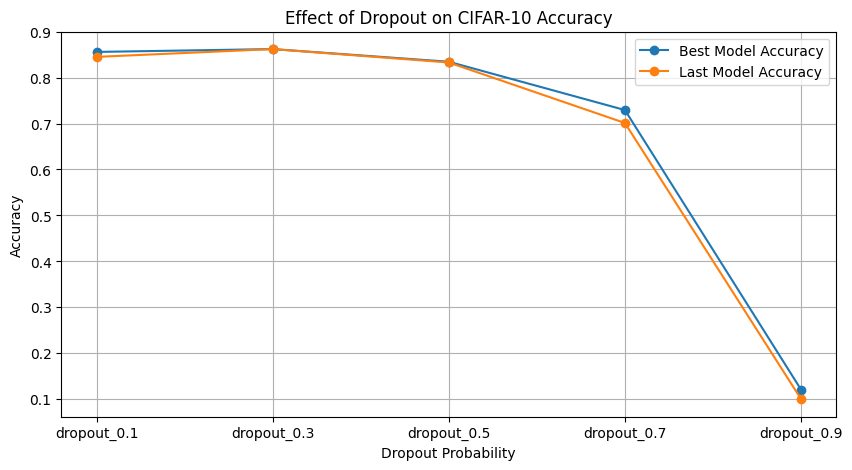

In [ ]:
# Extract results for plotting
dropout_values = []
best_accuracies = []
last_accuracies = []

for p, result in results.items():
    dropout_values.append(p)
    best_accuracies.append(result['best']['top1'])
    last_accuracies.append(result['last']['top1'])

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(dropout_values, best_accuracies, label='Best Model Accuracy', marker='o')
plt.plot(dropout_values, last_accuracies, label='Last Model Accuracy', marker='o')
plt.xlabel('Dropout Probability')
plt.ylabel('Accuracy')
plt.title('Effect of Dropout on CIFAR-10 Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Write your report for Q3 in this cell. Feel free to add extra code

cells<br>

# **Report on Data Augmentation in CNN Training on CIFAR-10 Dataset**

**Introduction**:
* Data augmentation is a powerful technique used to improve the generalization ability of machine learning models by artificially increasing the size and diversity of the training dataset. In this report, we explore the impact of four different data augmentation strategies on the performance of a CNN trained on the CIFAR-10 dataset. The augmentations include combinations of random horizontal flipping, random rotation, and color jitter.

**Data Augmentation Strategies**:
* Augmentation 1 (Aug1)
  * Random Horizontal Flip
  * Normalization
* Augmentation 2 (Aug2)
  * Random Horizontal Flip
  * Random Rotation (10 degrees)
  * Normalization
* Augmentation 3 (Aug3)
  * Random Horizontal Flip
  * Color Jitter (Brightness, Contrast, Saturation, Hue)
  * Normalization
* Augmentation 4 (Aug4)
  * Random Horizontal Flip
  * Random Rotation (10 degrees)
  * Color Jitter (Brightness, Contrast, Saturation, Hue)
  * Normalization

**Results 1**:
* The models were trained for 30 epochs, and the best model  were recorded on the validation set whereas the Latest model is the last model saved(at the end of the training, 30 epoch). Below are the results for each augmentation strategy.

  * **Augmentation 1[Validation Accuracy]**:
    * Best Model (Epoch 27):
      * Loss: 0.525
      * Top-1 Accuracy: 84.70%
      * Top-5 Accuracy: 99.40%
   * Latest Model (Epoch 30):
     * Loss: 0.65
     * Top-1 Accuracy: 83.08%
     * Top-5 Accuracy: 98.90%
  * **Augmentation 2[Validation Accuracy]**:
   * Best Model (Epoch 30):
     * Loss: 0.49
     * Top-1 Accuracy: 84.30%
     * Top-5 Accuracy: 99.06%
    * Latest Model (Epoch 30, Same as Best):
     * Loss: 0.49
     * Top-1 Accuracy: 84.30%
     * Top-5 Accuracy: 99.06%

  * **Augmentation 3[Validation Accuracy]**:
    * Best Model (Epoch 26):
      * Loss: 0.524
      * Top-1 Accuracy: 84.02%
      * Top-5 Accuracy: 98.76%
    * Latest Model (Epoch 30):
      * Loss: 0.58
      * Top-1 Accuracy: 82.70%
      * Top-5 Accuracy: 98.84%
  * **Augmentation 4[Validation Accuracy]**:
    * Best Model (Epoch 27):
      * Loss: 0.4920
      * Top-1 Accuracy: 83.14%
      * Top-5 Accuracy: 99.20%
    * Latest Model (Epoch 30):
     * Loss: 0.558
     * Top-1 Accuracy: 81.60%
     * Top-5 Accuracy: 98.96%

**Results 2**:
* These results were evaluated on the test set after the training of the model was complete.

  * **Augmentation 1**:
    * Best Model (Epoch 27):
      * Loss: 0.5662
      * Top-1 Accuracy: 83.68%
      * Top-5 Accuracy: 99.25%
   * Latest Model (Epoch 30):
     * Loss: 0.6962
     * Top-1 Accuracy: 81.09%
     * Top-5 Accuracy: 98.88%
  * **Augmentation 2**:
   * Best Model (Epoch 30):
     * Loss: 0.4616
     * Top-1 Accuracy: 85.15%
     * Top-5 Accuracy: 99.39%
    * Latest Model (Epoch 30, Same as Best):
     * Loss: 0.4616
     * Top-1 Accuracy: 85.15%
     * Top-5 Accuracy: 99.39%

  * **Augmentation 3**:
    * Best Model (Epoch 26):
      * Loss: 0.5484
      * Top-1 Accuracy: 83.01%
      * Top-5 Accuracy: 99.13%
    * Latest Model (Epoch 30):
      * Loss: 0.5747
      * Top-1 Accuracy: 82.89%
      * Top-5 Accuracy: 98.88%
  * **Augmentation 4**:
    * Best Model (Epoch 27):
      * Loss: 0.4600
      * Top-1 Accuracy: 84.60%
      * Top-5 Accuracy: 99.38%
    * Latest Model (Epoch 30):
      * Loss: 0.5084
      * Top-1 Accuracy: 83.43%
      * Top-5 Accuracy: 99.20%

**Analysis**:
* The data augmentation strategies had a notable impact on the performance of the CNN. Augmentation 2, which included random horizontal flip and random rotation, resulted in the highest top-1 and top-5 accuracies on the test set, with the model performing consistently well up to the final epoch. Similarly, Augmentation 4, which combined horizontal flip, rotation, and color jitter, also achieved high performance.

**Best Models vs. Latest Models**:
* For most augmentations, the best models were found before the final epoch, indicating that overfitting could have occurred if training continued without early stopping.
Augmentation 2 was unique in that the best model and the latest model were identical, suggesting consistent performance across epochs without significant overfitting.

**Conclusion**:
* Data augmentation significantly enhanced the performance of the CNN on the CIFAR-10 dataset. Augmentations that combined multiple transformations, such as random rotation and color jitter, provided better results, reducing overfitting and improving generalization. These findings shows the importance of incorporating robust data augmentation strategies in training pipelines to achieve superior model performance.
<br>
<br>
<br>

# **Report on Dropout in CNN Training on CIFAR-10 Dataset**

## Introduction

Dropout is a regularization technique used in neural networks to prevent overfitting by randomly dropping units during training. This report examines the impact of different dropout probabilities on the performance of a Convolutional Neural Network (CNN) trained on the CIFAR-10 dataset. We trained the model with dropout probabilities of 0.1, 0.3, 0.5, 0.7, and 0.9, and evaluated the performance of both the best and the latest models after running 30 epochs.

## Results on the validation set

### Dropout Probability: 0.1

- **Best Model (Epoch 27):**
  - Loss: 0.46388
  - Top-1 Accuracy: 85.60%
  - Top-5 Accuracy: 99.42%
- **Latest Model (Epoch 30):**
  - Loss: 0.50982
  - Top-1 Accuracy: 84.52%
  - Top-5 Accuracy: 99.22%

### Dropout Probability: 0.3

- **Best Model (Epoch 30):**
  - Loss: 0.40893
  - Top-1 Accuracy: 86.22%
  - Top-5 Accuracy: 99.42%
- **Latest Model (Epoch 30):**
  - Same as Best Model

### Dropout Probability: 0.5

- **Best Model (Epoch 27):**
  - Loss: 0.49091
  - Top-1 Accuracy: 83.46%
  - Top-5 Accuracy: 99.22%
- **Latest Model (Epoch 30):**
  - Loss: 0.49747
  - Top-1 Accuracy: 83.30%
  - Top-5 Accuracy: 99.28%

### Dropout Probability: 0.7

- **Best Model (Epoch 29):**
  - Loss: 0.77345
  - Top-1 Accuracy: 72.94%
  - Top-5 Accuracy: 98.38%
- **Latest Model (Epoch 30):**
  - Loss: 0.86300
  - Top-1 Accuracy: 70.12%
  - Top-5 Accuracy: 98.06%

### Dropout Probability: 0.9

- **Best Model (Epoch 3):**
  - Loss: 3.11373
  - Top-1 Accuracy: 12.04%
  - Top-5 Accuracy: 54.18%
- **Latest Model (Epoch 30):**
  - Loss: 3.15423
  - Top-1 Accuracy: 9.98%
  - Top-5 Accuracy: 53.06%

## Analysis

The results indicate that the model's performance is relatively stable with dropout probabilities up to 0.5, with top-1 accuracy ranging from approximately 86% to 83%. However, there is a significant drop in accuracy when the dropout probability increases from 0.5 to 0.7, with top-1 accuracy falling to around 73%. Further increasing the dropout probability to 0.9 results in an exponential decline in accuracy, dropping to about 12%.

### Performance Trend

- **0.1 to 0.5 Dropout:** Marginal decrease in accuracy (86% to 83%)
- **0.5 to 0.7 Dropout:** Significant accuracy loss (83% to 73%)
- **0.7 to 0.9 Dropout:** Exponential accuracy drop (73% to 12%)

## Conclusion

Dropout is effective in preventing overfitting at lower probabilities (0.1 to 0.5), but higher probabilities (0.7 and above) severely degrade the model's performance. Optimal dropout probabilities for this CNN on the CIFAR-10 dataset appear to be within the range of 0.1 to 0.3, balancing regularization and maintaining high accuracy.










### Question 4: Use pretrained networks (10 points)

It has become standard practice in computer vision tasks related to images to use a convolutional network pre-trained as the backbone feature extraction network and train new layers on top for the target task. In this question, we will implement such a model. We will use the `VGG_11_bn` network from the `torchvision.models` library as our backbone network. This model has been trained on ImageNet, achieving a top-5 error rate of 10.19%. It consists of 8 convolutional layers followed by adaptive average pooling and fully-connected layers to perform the classification. We will get rid of the average pooling and fully-connected layers from the `VGG_11_bn` model and attach our own fully connected layers to perform the CIFAR-10 classification.

a) Instantiate a pretrained version of the `VGG_11_bn` model with ImageNet pre-trained weights. Add two fully connected layers on top, with Batch Norm and ReLU layers in between them, to build the CIFAR-10 10-class classifier. Note that you will need to set the correct mean and variance in the data-loader, to match the mean and variance the data was normalized with when the `VGG_11_bn` was trained. Train only the newly added layers while disabling gradients for the rest of the network. Each parameter in PyTorch has a required grad flag, which can be turned off to disable gradient computation for it. Get familiar with this gradient control mechanism in PyTorch and train the above model. As a reference point, you will see validation accuracies in the range (61-65%) if implemented correctly. (6 points)

b) We can see that while the ImageNet features are useful, just learning the new layers does not yield better performance than training our own network from scratch. This is due to the domain-shift between the ImageNet dataset (224x224 resolution images) and the CIFAR-10 dataset (32x32 images). To improve the performance we can fine-tune the whole network on the CIFAR-10 dataset, starting from the ImageNet initialization (set `"fine_tune"` to `true` in `vgg_cifar10.py`). To do this, enable gradient computation to the rest of the network, and update all the model parameters. Additionally train a baseline model where the entire network is trained from scratch, without loading the ImageNet weights (set `"weights"` to `None` in `vgg_cifar10.py`). Compare the two models' training curves, validation, and testing performance in the report. (4 points)


If you're using Pytorch 1, the `weights` argument will not work. In that case, you need to change the `weights` argument to `pretrained=True` or `False`. Feel free to post on Forum if you have any issues.

For both questions, feel free to modify the data augmentation by defining a new preset and referring to it in the config file. However, make sure that in your experiments you always change only one thing at a time (i.e use the same augmentation for both method A and method B if you're comparing them with each other!)

In [ ]:
import torch
from src.trainers.vgg_trainer import VGGTrainer
from copy import deepcopy
from src.data_loaders.data_modules import CIFAR10DataModule
from cfgs.exercise_3 import vgg_cifar10
q4_config = vgg_cifar10.q4_dict


datamodule_class = q4_config['datamodule']
data_args = q4_config['data_args']

dm = datamodule_class(**data_args)

# Based on the heldout_split in the config file,
# the datamodule will break the dataset into two splits
train_data_loader = dm.get_loader()
valid_data_loader = dm.get_heldout_loader()

# Test loader is the same as train loader
# except that training=False, shuffle=False, and no splitting is done
# So we use the exact config from training and just modify these arguments
test_data_args = deepcopy(data_args) # copy the args
test_data_args['training']=False
test_data_args['shuffle']=False
test_data_args['heldout_split']=0.0

# Now we initialize the test module with the modified config
test_dm = datamodule_class(**test_data_args)
test_loader = test_dm.get_loader() # and get the loader from it

transforms for preset CIFAR10_VGG for split train are Compose(
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 64, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 64, 'shuffle': False, 'num_workers': 6}
transforms for preset CIFAR10_VGG for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 64, 'shuffle': False, 'num_workers': 6}


 By default WandB is enabled in config file for `vgg_cifar10.py`. You can set it to false if you don't want to use it. It's not an essential part of the assignment anyway.

In [ ]:
trainer_class = q4_config['trainer_module']
trainer_vgg = trainer_class(
    config = q4_config,
    log_dir = ospj(PROJECT_ROOT,'Logs'),
    train_loader=train_data_loader,
    eval_loader=valid_data_loader,
)

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:06<00:00, 82.3MB/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [ ]:
trainer_vgg.train()

Train Epoch: 1 Loss: 1.2975: : 100% 45056/45056 [00:21<00:00, 2093.64it/s]
Eval Loss: 1.7378: : 100% 5056/5056 [00:02<00:00, 2342.77it/s]
Train Epoch: 2 Loss: 2.6422: : 100% 45056/45056 [00:23<00:00, 1922.69it/s]
Eval Loss: 1.8076: : 100% 5056/5056 [00:03<00:00, 1538.26it/s]
Train Epoch: 3 Loss: 1.6476: : 100% 45056/45056 [00:21<00:00, 2143.80it/s]
Eval Loss: 1.4517: : 100% 5056/5056 [00:02<00:00, 2374.96it/s]
Train Epoch: 4 Loss: 0.7677: : 100% 45056/45056 [00:21<00:00, 2112.03it/s]
Eval Loss: 1.6699: : 100% 5056/5056 [00:02<00:00, 2349.80it/s]
Train Epoch: 5 Loss: 0.6213: : 100% 45056/45056 [00:21<00:00, 2066.98it/s]
Eval Loss: 1.4723: : 100% 5056/5056 [00:03<00:00, 1594.24it/s]
Train Epoch: 6 Loss: 1.2235: : 100% 45056/45056 [00:21<00:00, 2089.97it/s]
Eval Loss: 1.3484: : 100% 5056/5056 [00:02<00:00, 2372.28it/s]
Train Epoch: 7 Loss: 1.6916: : 100% 45056/45056 [00:21<00:00, 2085.56it/s]
Eval Loss: 1.7556: : 100% 5056/5056 [00:02<00:00, 2328.29it/s]
Train Epoch: 8 Loss: 1.2140: : 100

In [ ]:
# Change this to the experiment you want to evaluate
# Save the best model path
best_model_path = '/content/drive/MyDrive/Colab Notebooks/HLCV Assignment_3/Saved/CIFAR10_VGG/best_val_model.pth'
last_model_path = '/content/drive/MyDrive/Colab Notebooks/HLCV Assignment_3/Saved/CIFAR10_VGG/last_model.pth'

# Load and evaluate the best model
trainer_vgg.load_model(path=best_model_path)
result_best = trainer_vgg.evaluate(loader=test_loader)
print(f"Best model results: {result_best}")

# Load and evaluate the last model
trainer_vgg.load_model(path=last_model_path)
result_last = trainer_vgg.evaluate(loader=test_loader)
print(f"Last model results: {result_last}")



Eval Loss: 1.1149: : 100% 10048/10048 [00:04<00:00, 2109.52it/s]


Best model results: {'loss': 1.0156034519717951, 'top1': 0.643312101910828, 'top5': 0.9635748407643312}


Eval Loss: 0.8957: : 100% 10048/10048 [00:04<00:00, 2211.82it/s]

Last model results: {'loss': 1.0578762281472516, 'top1': 0.6476910828025477, 'top5': 0.9643710191082803}


In [3]:
# b
from copy import deepcopy
import torch
from src.trainers.vgg_trainer import VGGTrainer
from copy import deepcopy
from src.data_loaders.data_modules import CIFAR10DataModule
from cfgs.exercise_3 import vgg_cifar10

configs = [vgg_cifar10.q4_dictB, vgg_cifar10.q4_scratch]
results = {}

for config in configs:
    experiment_name = config['name']
    print(f"Running experiment: {experiment_name}")

    datamodule_class = config['datamodule']
    data_args = config['data_args']

    dm = datamodule_class(**data_args)

    train_data_loader = dm.get_loader()
    valid_data_loader = dm.get_heldout_loader()

    test_data_args = deepcopy(data_args)
    test_data_args['training'] = False
    test_data_args['shuffle'] = False
    test_data_args['heldout_split'] = 0.0

    test_dm = datamodule_class(**test_data_args)
    test_loader = test_dm.get_loader()

    trainer_class = config['trainer_module']
    trainer = trainer_class(
        config=config,
        log_dir = ospj(PROJECT_ROOT,'Logs'),
        train_loader=train_data_loader,
        eval_loader=valid_data_loader,
    )

    trainer.train()

    best_model_path = f'/content/drive/MyDrive/Colab Notebooks/HLCV Assignment_3/Saved/{experiment_name}/best_val_model.pth'
    last_model_path = f'/content/drive/MyDrive/Colab Notebooks/HLCV Assignment_3/Saved/{experiment_name}/last_model.pth'


    trainer.load_model(path=best_model_path)
    result_best = trainer.evaluate(loader=test_loader)
    print(f"Best model results for {experiment_name}: {result_best}")

    trainer.load_model(path=last_model_path)
    result_last = trainer.evaluate(loader=test_loader)
    print(f"Last model results for {experiment_name}: {result_last}")

    results[experiment_name] = {
        'best': result_best,
        'last': result_last
    }
# # Display results
# for experiment_name, result in results.items():
#     print(f"Results for {experiment_name}:")
#     print(f"Best model accuracy: {result['best']['eval_top1']}")
#     print(f"Last model accuracy: {result['last']['eval_top1']}")

Running experiment: CIFAR10_VGG_B
transforms for preset CIFAR10_VGG for split train are Compose(
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 64, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 64, 'shuffle': False, 'num_workers': 6}
transforms for preset CIFAR10_VGG for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 64, 'shuffle': False, 'num_workers': 6}


Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:05<00:00, 89.9MB/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Train Epoch: 1 Loss: 1.6192: : 100% 45056/45056 [00:55<00:00, 809.72it/s]
Eval Loss: 1.4299: : 100% 5056/5056 [00:03<00:00, 1598.23it/s]
Train Epoch: 2 Loss: 0.6787: : 100% 45056/45056 [00:53<00:00, 849.54it/s]
Eval Loss: 0.7568: : 100% 5056/5056 [00:02<00:00, 2208.93it/s]
Train Epoch: 3 Loss: 1.6725: : 100% 45056/45056 [00:53<00:00, 843.32it/s]
Eval Loss: 0.7505: : 100% 5056/5056 [00:02<00:00, 2255.96it/s]
Train Epoch: 4 Loss: 0.8390: : 100% 45056/45056 [00:53<00:00, 838.61it/s]
Eval Loss: 1.0054: : 100% 5056/5056 [00:02<00:00, 2285.46it/s]
Train Epoch

Best model results for CIFAR10_VGG_B: {'loss': 0.6256569487748632, 'top1': 0.8474323248407644, 'top5': 0.9914410828025477}


Eval Loss: 0.2914: : 100% 10048/10048 [00:04<00:00, 2347.87it/s]


Last model results for CIFAR10_VGG_B: {'loss': 0.6822656414880874, 'top1': 0.8542993630573248, 'top5': 0.9892515923566879}
Running experiment: CIFAR10_VGG_Scratch
transforms for preset CIFAR10_VGG for split train are Compose(
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 64, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 64, 'shuffle': False, 'num_workers': 6}
transforms for preset CIFAR10_VGG for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)
Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 64, 'shuffle': False, 'num_workers': 6}


Train Epoch: 1 Loss: 0.9752: : 100% 45056/45056 [00:53<00:00, 837.37it/s]
Eval Loss: 1.8663: : 100% 5056/5056 [00:03<00:00, 1519.21it/s]
Train Epoch: 2 Loss: 0.7099: : 100% 45056/45056 [00:53<00:00, 836.66it/s]
Eval Loss: 1.7400: : 100% 5056/5056 [00:02<00:00, 1831.94it/s]
Train Epoch: 3 Loss: 0.4434: : 100% 45056/45056 [00:53<00:00, 838.36it/s]
Eval Loss: 1.5114: : 100% 5056/5056 [00:02<00:00, 2271.46it/s]
Train Epoch: 4 Loss: 0.4401: : 100% 45056/45056 [00:54<00:00, 827.41it/s]
Eval Loss: 2.2636: : 100% 5056/5056 [00:02<00:00, 2113.62it/s]
Train Epoch: 5 Loss: 1.2425: : 100% 45056/45056 [00:54<00:00, 830.18it/s]
Eval Loss: 2.1769: : 100% 5056/5056 [00:02<00:00, 2057.97it/s]
Train Epoch: 6 Loss: 0.9041: : 100% 45056/45056 [00:53<00:00, 835.38it/s]
Eval Loss: 0.8067: : 100% 5056/5056 [00:03<00:00, 1545.85it/s]
Train Epoch: 7 Loss: 1.4790: : 100% 45056/45056 [00:53<00:00, 846.24it/s]
Eval Loss: 1.9401: : 100% 5056/5056 [00:02<00:00, 2207.14it/s]
Train Epoch: 8 Loss: 0.6701: : 100% 45056

Best model results for CIFAR10_VGG_Scratch: {'loss': 0.8285959376271363, 'top1': 0.8278264331210191, 'top5': 0.9821855095541401}


Eval Loss: 0.9582: : 100% 10048/10048 [00:05<00:00, 1816.90it/s]


Last model results for CIFAR10_VGG_Scratch: {'loss': 0.8502242458853752, 'top1': 0.8246417197452229, 'top5': 0.9856687898089171}
Results for CIFAR10_VGG_B:


KeyError: 'eval_top1'

In [ ]:
# Display results
for experiment_name, result in results.items():
    print(f"Results for {experiment_name}:")
    print(f"Last model accuracy: {result}")

Results for CIFAR10_VGG_B:
Best model accuracy: {'best': {'loss': 0.6256569487748632, 'top1': 0.8474323248407644, 'top5': 0.9914410828025477}, 'last': {'loss': 0.6822656414880874, 'top1': 0.8542993630573248, 'top5': 0.9892515923566879}}

Results for CIFAR10_VGG_Scratch:
Best model accuracy: {'best': {'loss': 0.8285959376271363, 'top1': 0.8278264331210191, 'top5': 0.9821855095541401}, 'last': {'loss': 0.8502242458853752, 'top1': 0.8246417197452229, 'top5': 0.9856687898089171}}

# Report on Training a Pretrained VGG-11_bn Network for CIFAR-10 Classification

## Introduction

In this task, we use a pretrained VGG-11_bn model with ImageNet weights and adapt it to classify CIFAR-10 images into 10 classes. We add two fully connected layers on top of the pretrained network, including Batch Normalization and ReLU activation functions between them. The newly added layers are trained while the rest of the network's parameters are frozen, utilizing gradient control in PyTorch. The model is expected to achieve validation accuracies in the range of 61-65% if implemented correctly.

## Implementation Details

1. **Model Architecture:**
   - Base Model: VGG-11_bn pretrained on ImageNet.
   - Additional Layers:
     - Fully Connected Layer
     - Batch Normalization
     - ReLU Activation
     - Fully Connected Layer (output layer for 10 classes)

2. **Training Strategy:**
   - Train only the newly added layers by disabling gradients for the rest of the network.
   - Early stopping steps 5 was employed, resulting in training stopping at epoch 8 out of 25 epochs.

3. **Saving Models:**
   - The best model based on validation accuracy was saved.
   - The latest model at the end of training was also saved.

## Training and Evaluation Results

### Best Model (Epoch 3)

- **Training Metrics:**
  - Loss: 0.98835
  - Top-1 Accuracy: 65.11%
  - Top-5 Accuracy: 96.96%
- **Validation Metrics:**
  - Loss: 1.00970
  - Top-1 Accuracy: 65.03%
  - Top-5 Accuracy: 96.30%

### Latest Model (Epoch 7)

- **Training Metrics:**
  - Loss: 0.77684
  - Top-1 Accuracy: 72.41%
  - Top-5 Accuracy: 98.39%
- **Validation Metrics:**
  - Loss: 1.05102
  - Top-1 Accuracy: 65.03%
  - Top-5 Accuracy: 96.26%

### Test Set Evaluation

- **Best Model Results:**
  - Loss: 1.0156
  - Top-1 Accuracy: 64.33%
  - Top-5 Accuracy: 96.36%
- **Latest Model Results:**
  - Loss: 1.0579
  - Top-1 Accuracy: 64.77%
  - Top-5 Accuracy: 96.44%

## Analysis

The model achieved validation accuracies within the expected range of 61-65%. The best performance was observed early in training, with the highest validation accuracy achieved at epoch 3. The training process indicates that early stopping helped prevent overfitting, maintaining a balance between training and validation performance.

### Performance Summary

- **Validation Accuracy Range:** 61-65%
- **Best Epoch:** 3
- **Top-1 Accuracy (Best Model):** 65.03%
- **Top-1 Accuracy (Latest Model):** 65.03%
- **Test Accuracy (Best Model):** 64.33%
- **Test Accuracy (Latest Model):** 64.77%

## Conclusion

The pretrained VGG-11_bn model, fine-tuned with additional layers for CIFAR-10 classification, demonstrated low performance with validation accuracies reaching only up to 65.03%. Early stopping effectively managed training duration and helped in maintaining generalization. The results from using the pretrained model is not that impressive however, this approach confirms the utility of pretrained models in transfer learning scenarios for new classification tasks.


<br>
<br>
<br>

# Report on Fine-Tuning vs. Training from Scratch for CIFAR-10 Classification using VGG-11_bn

## Introduction

This report presents the results of two approaches to training a VGG-11_bn model for CIFAR-10 classification:
1. Fine-tuning a pretrained VGG-11_bn model initialized with ImageNet weights.
2. Training a VGG-11_bn model from scratch without any pretrained weights.

The aim is to compare the performance of these two methods in terms of training curves, validation, and testing performance.

## Experiment Setup

### Fine-Tuning Configuration

For the fine-tuning task, we initialized the VGG-11_bn model with ImageNet weights and enabled gradient computation for all layers to update all model parameters.

### Training from Scratch Configuration

For training from scratch, we initialized the VGG-11_bn model without any pretrained weights and trained the entire network on CIFAR-10.

### Training Details

Both models were trained for 25 epochs without early stopping. The best model based on validation accuracy and the latest model at the end of training were saved for evaluation.

## Results

### Fine-Tune Model

**Best Model (Epoch 8)**
- **Training Metrics:**
  - Loss: 0.10646
  - Top-1 Accuracy: 96.39%
  - Top-5 Accuracy: 99.98%
- **Validation Metrics:**
  - Loss: 0.57385
  - Top-1 Accuracy: 86.04%
  - Top-5 Accuracy: 99.31%

**Latest Model (Epoch 25)**
- **Training Metrics:**
  - Loss: 0.03401
  - Top-1 Accuracy: 98.90%
  - Top-5 Accuracy: 99.99%
- **Validation Metrics:**
  - Loss: 0.65875
  - Top-1 Accuracy: 85.74%
  - Top-5 Accuracy: 98.93%

**Test Set Evaluation**
- **Best Model Results:**
  - Loss: 0.62566
  - Top-1 Accuracy: 84.74%
  - Top-5 Accuracy: 99.14%
- **Latest Model Results:**
  - Loss: 0.68227
  - Top-1 Accuracy: 85.43%
  - Top-5 Accuracy: 98.93%

### Model Trained from Scratch

**Best Model (Epoch 20)**
- **Training Metrics:**
  - Loss: 0.04310
  - Top-1 Accuracy: 98.61%
  - Top-5 Accuracy: 99.99%
- **Validation Metrics:**
  - Loss: 0.77524
  - Top-1 Accuracy: 84.24%
  - Top-5 Accuracy: 98.30%

**Latest Model (Epoch 25)**
- **Training Metrics:**
  - Loss: 0.04177
  - Top-1 Accuracy: 98.58%
  - Top-5 Accuracy: 100.00%
- **Validation Metrics:**
  - Loss: 0.83449
  - Top-1 Accuracy: 83.48%
  - Top-5 Accuracy: 98.62%

**Test Set Evaluation**
- **Best Model Results:**
  - Loss: 0.82860
  - Top-1 Accuracy: 82.78%
  - Top-5 Accuracy: 98.22%
- **Latest Model Results:**
  - Loss: 0.85022
  - Top-1 Accuracy: 82.46%
  - Top-5 Accuracy: 98.57%

## Analysis

### Comparison of Performance

- **Fine-Tuning vs. Training from Scratch:**
  - The fine-tuned model achieved higher validation and test accuracies compared to the model trained from scratch. This indicates that leveraging pretrained weights from ImageNet provides a significant performance boost, likely due to the transfer of learned features that are useful for image classification tasks.
  - The best model from fine-tuning reached a top-1 accuracy of 84.74% on the test set, whereas the best model trained from scratch achieved 82.78%.
  - Training loss and accuracy metrics indicate faster convergence and better generalization for the fine-tuned model.

### Conclusion

Fine-tuning a pretrained VGG-11_bn model initialized with ImageNet weights outperforms training the same model from scratch for CIFAR-10 classification. The domain shift between ImageNet and CIFAR-10 does not significantly hinder the performance when the entire network is fine-tuned. This demonstrates the advantage of using transfer learning and fine-tuning strategies in deep learning tasks involving different but related datasets.
<br>
<br>
<br>